## Dynamic graph 3D Plotting

### Import Libraries

In [1]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact

import igraph as ig
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

Let's plot a random graph of N nodes, edges linked randomly, with random edges.

In [2]:
num = 20
graph = nx.Graph()
for node in range(0,num+1):
    graph.add_node(node, val=node)
    graph.add_edge(node, random.randint(0,num), weight=random.randint(10,20))
    #Link Adjacent nodes
    if node != num:
        graph.add_edge(node, node+1, weight=random.randint(10,20))
        
L = len(graph.edges())
N = len(graph.nodes())
labels = [k for k in graph.nodes()]
edges = [(u,v) for u,v in graph.edges()]
G =ig.Graph(edges, directed = False)

In [3]:
pos = nx.fruchterman_reingold_layout(graph)
layt = G.layout(layout='fr', dim =3)

In [4]:
graph2 = nx.Graph()
graph2.add_nodes_from(graph.nodes(data = True))
for u,v in graph.edges():
    graph2.add_edge(u,v, weight=1)
for node in graph2.nodes(data = True):
    node[1]['val'] = random.randint(7, 30)
    
L2 = len(graph2.edges())
N2 = len(graph2.nodes())

Let's create the list of weights used to modify the width of our edges

In [5]:
weights=nx.get_edge_attributes(graph,'weight')
weight_list = list(weights.values())
weights2=nx.get_edge_attributes(graph2,'weight')
weight_list2 = list(weights2.values())
edge_color = [x/5 for x in weight_list]
edge_color2 =[x/5 for x in weight_list2]

nodes_val=nx.get_node_attributes(graph,'val')
nodes_val2=nx.get_node_attributes(graph2,'val')
node_width = [x*80+5 for x in nodes_val]
node_width2 =[x*80+5 for x in nodes_val2]


We plot here a random graph with random weights. This is our starter graph.

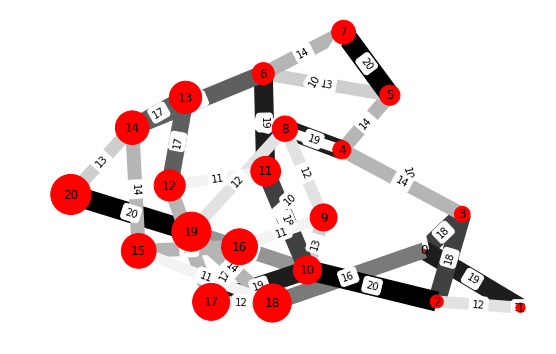

In [6]:
plt.figure(figsize=(20,20))
plt.subplot(321)
nx.draw(graph , pos = pos, width = weight_list , with_labels=True, node_size=node_width, edge_color=edge_color, edge_cmap= plt.cm.Greys)
nx.draw_networkx_edge_labels(graph,pos = pos,edge_labels=weights)
plt.show()

And for this one, this is the last graph we want to obtain.

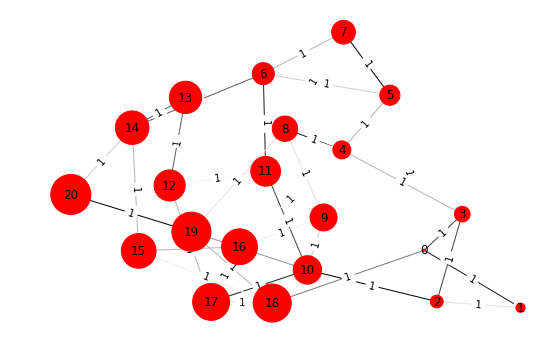

In [7]:
plt.figure(figsize=(20,20))
plt.subplot(322)
nx.draw(graph2 , pos = pos, width = weight_list2 , with_labels=True, node_size=node_width2, edge_labels= weight_list2, edge_color=edge_color, edge_cmap= plt.cm.Greys)
nx.draw_networkx_edge_labels(graph,pos = pos,edge_labels=weights2)
plt.show()

This method computes the linear affine combination between the starter graph and the last graph. The method plots the new graph such that it respects the following equation:
- (1-t)*G1 + t*G2, with t from [0,1]

It returns a list of different linear affine combination, with respect to the variable t.

In [8]:
def comb_graph(g1, g2):
    graphs_list = []
    ranger = [x * 0.1 for x in range(1, 11)]
    for t in ranger:
        g = nx.Graph()
        for u in g1.edges(data = True):
            for v in g2.edges(data = True):
                if u[:-1] == v[:-1]:
                    weighty = int((1-t)*(u[2].get('weight')) + (t+0.1)*(v[2].get('weight')))
                    g.add_edge(u[0], u[1], weight = weighty)
        graphs_list.append(g)
    return graphs_list

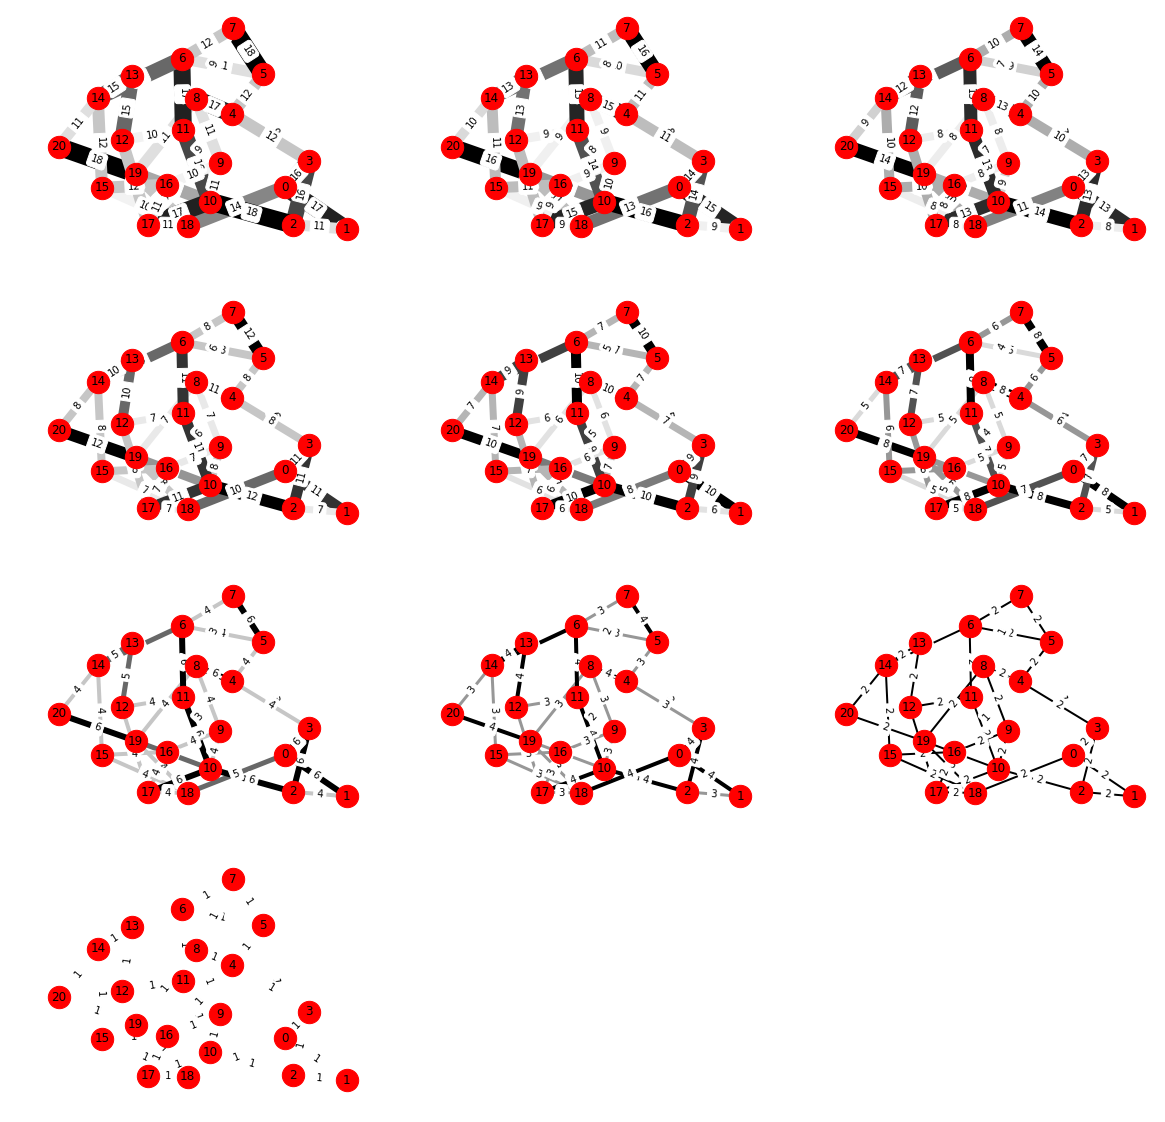

In [9]:
a = comb_graph(graph, graph2)
fig = plt.figure(figsize=(20,20))
for i in range(0, len(a)):
    weights = nx.get_edge_attributes(a[i],'weight')
    weight_list = list(weights.values())
    edge_color = [x/5 for x in weight_list]
    fig.add_subplot(4,3, i+1)
    nx.draw(a[i] , pos = pos, width = weight_list , with_labels=True, node_size=500, edge_color=edge_color, edge_cmap= plt.cm.Greys)
    nx.draw_networkx_edge_labels(a[i],pos = pos,edge_labels=weights)

In [10]:
Xn=[layt[k][0] for k in range(N)]# x-coordinates of nodes
Yn=[layt[k][1] for k in range(N)]# y-coordinates
Zn=[layt[k][2] for k in range(N)]# z-coordinates
Xe=[]
Ye=[]
Ze=[]
for e in edges:
    Xe+=[layt[e[0]][0],layt[e[1]][0], None]# x-coordinates of edge ends
    Ye+=[layt[e[0]][1],layt[e[1]][1], None]  
    Ze+=[layt[e[0]][2],layt[e[1]][2], None]  

In [11]:
trace1=go.Scatter3d(x=Xe,
               y=Ye,
               z=Ze,
               mode='lines',
               line=dict(color='rgb(125,125,125)', width=1),
               hoverinfo='none'
               )

trace2=go.Scatter3d(x=Xn,
               y=Yn,
               z=Zn,
               mode='markers',
               name='actors',
               marker=dict(symbol='circle',
                             size=6,
                             color='blue',
                             colorscale='Viridis',
                             line=dict(color='rgb(50,50,50)', width=0.5)
                             ),
               text=labels,
               hoverinfo='text'
               )
axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )

layout = go.Layout(
         title="Random 3D Network",
         width=1000,
         height=1000,
         showlegend=False,
         scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),
     margin=dict(
        t=100
    ),
    hovermode='closest',
    )

In [12]:
data=[trace1, trace2]
fig=go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Random Net')

Now, because we don't really see how the edge weights evolve, let's compute it in a way we can interact with it. Thus, we are able to choose the value of the variable t.

In [13]:
@interact(t=(0,1,0.1))
def plotgraph(t):
    g = nx.Graph()
    
    for node in graph.nodes(data = True):  
        for node2 in graph2.nodes(data = True):
            if node[0] == node2[0]:
                g.add_node(node[0], val = int((1-t)*(node[1].get('val')) + t*(node2[1].get('val'))))
                
    for u in graph.edges(data = True):
        for v in graph2.edges(data = True):
            if u[:-1] == v[:-1]:
                weighty = int((1-t)*(u[2].get('weight')) + t*(v[2].get('weight')))
                g.add_edge(u[0], u[1], weight = weighty)
                
    weights = nx.get_edge_attributes(g,'weight')
    weight_list = list(weights.values())
    edge_color = [x/5 for x in weight_list]
    nodes_val_g = nx.get_node_attributes(g,'val').values()
    node_width_g = [x*80 + 5 for x in nodes_val_g]
    
    M = g.number_of_edges()
    edge_colors = range(2, M + 2)
    edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
    
    nx.draw(g , pos = pos, width = weight_list , with_labels=True,node_size=node_width_g, edge_color=edge_colors, edge_cmap= plt.cm.Greys)
    nx.draw_networkx_edge_labels(g,pos = pos,edge_labels=weights)

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0), Output()), _dom_classes=('widget-inter…

In [68]:
    t= 0.5
    g = nx.Graph()
    
    for node in graph.nodes(data = True):  
        for node2 in graph2.nodes(data = True):
            if node[0] == node2[0]:
                g.add_node(node[0], val = int((1-t)*(node[1].get('val')) + t*(node2[1].get('val'))))
                
    for u in graph.edges(data = True):
        for v in graph2.edges(data = True):
            if u[:-1] == v[:-1]:
                weighty = int((1-t)*(u[2].get('weight')) + t*(v[2].get('weight')))
                g.add_edge(u[0], u[1], weight = weighty)
                
    weights = nx.get_edge_attributes(g,'weight')
    weight_list = list(weights.values())
    edge_color = [x/5 for x in weight_list]
    nodes_val_g = nx.get_node_attributes(g,'val').values()
    node_width_g = [x*80 + 5 for x in nodes_val_g]    
    
    trace1=go.Scatter3d(x=Xe,
               y=Ye,
               z=Ze,
               mode='lines',
               line=dict(color=edge_color, colorscale='Greys', width=2),
               hoverinfo='none',
               )

    trace2=go.Scatter3d(x=Xn,
               y=Yn,
               z=Zn,
               mode='markers',
               name='actors',
               marker=dict(symbol='circle',
                             size=8,
                             color='blue',
                             line=dict(color='rgb(50,50,50)', width=5)
                             ),
               text=labels,
               hoverinfo='text'
               )

    data=[trace1, trace2]
    fig=go.Figure(data=data, layout=layout)

    
    py.iplot(fig, filename='Random 3D Network')

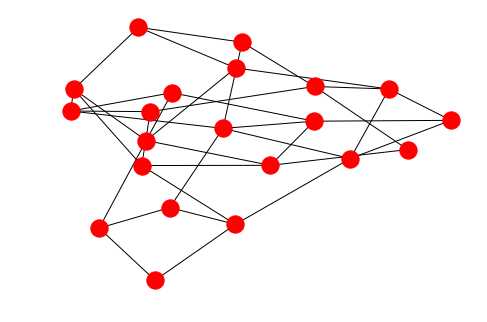

In [53]:
netG = G.get_edgelist()
netgraph = nx.Graph(netG)
nx.draw(netgraph)